# Normalização de Batch

A normalização de batches foi introduzida no artigo de 2015 de Sergey Ioffe e Christian Szegedy [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). A ideia é que, em vez de apenas normalizar as entradas para a rede, normalizemos também as entradas para _cada camada dentro_ da rede.
> Chama-se normalização **batch** porque, durante o treinamento, normalizamos as entradas de cada camada usando a média e a variação dos valores no *batch* atual.

## Normalização de Batches no PyTorch

Esta seção mostra uma maneira de adicionar a normalização em batch a uma rede neural construída no PyTorch.

As células a seguir importam os pacotes necessários e carregam o dataset MNIST para usar em nossos experimentos.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False,
                           download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

### Visualizando os Dados

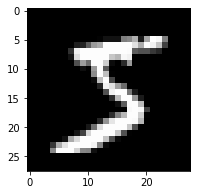

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Classes de rede neural para teste

A classe a seguir, `NeuralNet`, permite criar redes neurais idênticas **com e sem normalização de batches** para comparação. Os comentários nos blocos de código podem responder a algumas de suas perguntas.

* Sobre o código: *
> Estamos definindo um MLP simples para classificação; essa escolha de design foi feita para apoiar a discussão relacionada à normalização de batches e não para obter a melhor acurácia na classificação.

### (Importante) Detalhes do modelo

Existem alguns comentários no código, portanto, eles devem responder à maioria das suas perguntas. No entanto, vamos dar uma olhada nas linhas mais importantes.

Adicionamos normalização em lote às camadas dentro da função `__init__`. Aqui estão alguns pontos importantes sobre esse código:
1. Camadas com normalização de batch **não** incluem um elemento de deslocamento (bias b).
2. Usamos a função do PyTorch [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d) para lidar com a matemática. Esta é a função que vamos usar para operar nas saídas das camadas lineares; você usará [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) para saídas 2D, como imagens filtradas de camadas convolucionais.
3. Adicionamos a camada de normalização em batches **antes** de chamar a função de ativação.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size=784, hidden_dim=256, output_size=10):
        """
        Creates a PyTorch net using the given parameters.
        
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        super(NeuralNet, self).__init__() # init super
        
        # Default layer sizes
        self.input_size = input_size # (28*28 images)
        self.hidden_dim = hidden_dim
        self.output_size = output_size # (number of classes)
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        # define hidden linear layers, with optional batch norm on their outputs
        # layers with batch_norm applied have no bias term
        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
        else:
            self.fc1 = nn.Linear(input_size, hidden_dim*2)
            
        # define *second* hidden linear layers, with optional batch norm on their outputs
        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        else:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # third and final, fully-connected layer
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers + optional batch norm + relu activation
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        # second layer
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        # third layer, no batch norm or activation
        x = self.fc3(x)
        return x


### Criando dois modelos diferentes para teste

* `net_batchnorm` é um modelo de classificação linear **com** normalização de batch aplicada à saída de suas camadas ocultas
* `net_no_norm` é um MLP simples, sem normalização de batch

Além das camadas de normalização, o resto desses modelos é o mesmo.

In [5]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_norm = NeuralNet(use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


---
## Treinamento

A função `train` abaixo receberá um modelo e um número de épocas. Usaremos o erro de entropia cruzada e o gradiente descendente estocástico para otimização. Essa função retorna os erros, registradas após cada época, para que possamos exibir e comparar o comportamento de diferentes modelos.

#### `.train ()`
Note que dizemos ao nosso modelo se ele deve ou não estar no modo de treinamento, `model.train ()`. Essa é uma etapa importante porque a normalização de batches tem um comportamento diferente durante o treinamento em um batch ou o teste/avaliação em um conjunto de dados maior.

In [6]:
def train(model, n_epochs=10):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []
        
    # optimization strategy 
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()
    
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1                

        # print training statistics 
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss/batch_count))
    
    # return all recorded batch losses
    return losses
        
      

### Comparando Modelos

Nas células abaixo, iremos treinar nossos dois modelos e, então, compará-los.

In [7]:
# batchnorm model losses
# this may take some time to train
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	Training Loss: 0.388271
Epoch: 2 	Training Loss: 0.164134
Epoch: 3 	Training Loss: 0.114526
Epoch: 4 	Training Loss: 0.085772
Epoch: 5 	Training Loss: 0.066044
Epoch: 6 	Training Loss: 0.051548
Epoch: 7 	Training Loss: 0.040457
Epoch: 8 	Training Loss: 0.031867
Epoch: 9 	Training Loss: 0.025188
Epoch: 10 	Training Loss: 0.020043


In [8]:
# *no* norm model losses
# you should already start to see a difference in training losses
losses_no_norm = train(net_no_norm)

Epoch: 1 	Training Loss: 1.602603
Epoch: 2 	Training Loss: 0.511139
Epoch: 3 	Training Loss: 0.379990
Epoch: 4 	Training Loss: 0.335018
Epoch: 5 	Training Loss: 0.307067
Epoch: 6 	Training Loss: 0.285241
Epoch: 7 	Training Loss: 0.266389
Epoch: 8 	Training Loss: 0.249199
Epoch: 9 	Training Loss: 0.233294
Epoch: 10 	Training Loss: 0.218585


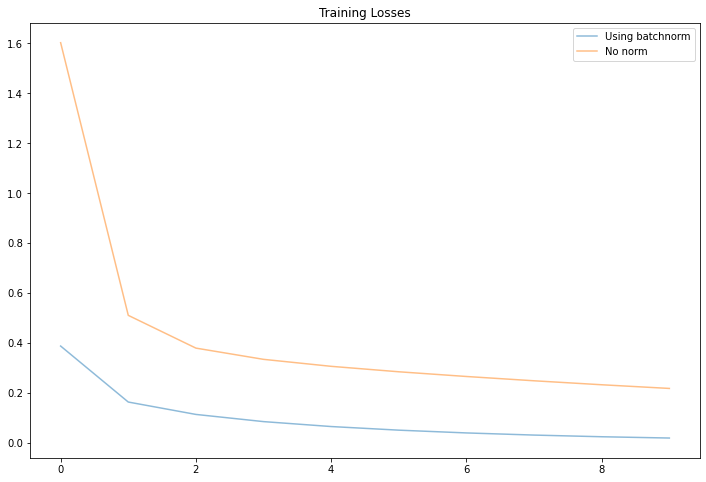

In [9]:
# compare
fig, ax = plt.subplots(figsize=(12,8))
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_batchnorm, label='Using batchnorm', alpha=0.5)
plt.plot(losses_no_norm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Teste

Observe que o modelo com normalização de batches começa com uma menor perda de treinamento e, em mais de dez épocas de treinamento, atinge uma perda de treinamento visivelmente mais baixa que o modelo sem normalização.

A seguir, vamos ver o desempenho de ambos os modelos em nossos dados de teste! Abaixo, temos uma função `test` que recebe um modelo e um parâmetro `train` (True ou False) que indica se o modelo deve estar no modo de treinamento ou de avaliação. Isso é para fins de comparação, mais tarde. Essa função calculará algumas estatísticas de teste, incluindo a precisão geral do teste de um modelo.

In [10]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += loss.item()*batch_size
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

### Modo de treinamento e avaliação

A configuração de um modelo no modo de avaliação é importante para modelos com camadas de normalização de batch!

* Modo de treinamento significa que as camadas de normalização do batch usarão estatísticas **em batch** para calcular a norma do batch.
* O modo de avaliação, por outro lado, usa a média e a variação estimadas de **população** de todo o conjunto de treinamento, o que deve fornecer um desempenho aprimorado nesses dados de teste!

In [11]:
# test batchnorm case, in *train* mode
test(net_batchnorm, train=True)

Test Loss: 0.081110

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1002/1032)
Test Accuracy of     3: 97% (985/1010)
Test Accuracy of     4: 96% (949/982)
Test Accuracy of     5: 97% (868/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 96% (939/974)
Test Accuracy of     9: 96% (971/1009)

Test Accuracy (Overall): 97% (9740/10000)


In [12]:
# test batchnorm case, in *evaluation* mode
test(net_batchnorm, train=False)

Test Loss: 0.068478

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1011/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (953/982)
Test Accuracy of     5: 98% (879/892)
Test Accuracy of     6: 97% (937/958)
Test Accuracy of     7: 96% (994/1028)
Test Accuracy of     8: 96% (937/974)
Test Accuracy of     9: 97% (987/1009)

Test Accuracy (Overall): 97% (9785/10000)


In [13]:
# for posterity, test no norm case in eval mode
test(net_no_norm, train=False)

Test Loss: 0.210387

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 90% (936/1032)
Test Accuracy of     3: 92% (939/1010)
Test Accuracy of     4: 94% (924/982)
Test Accuracy of     5: 92% (825/892)
Test Accuracy of     6: 94% (908/958)
Test Accuracy of     7: 92% (956/1028)
Test Accuracy of     8: 90% (882/974)
Test Accuracy of     9: 93% (939/1009)

Test Accuracy (Overall): 93% (9388/10000)


### Qual modelo tem a maior precisão?

Você verá uma pequena melhoria ao comparar a precisão do modelo com normalização de batches no modo de treinamento e avaliação; **modo de avaliação** deve dar uma pequena melhoria!

Você também deve ver que o modelo que usa camadas de normalização de batch mostra uma melhoria acentuada na precisão geral quando comparado ao modelo não normalizado